In [156]:
import random
import itertools

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection

In [157]:
def createLSTMLayers(n_layers, n_cells, dropout):
    cell_list = []
    
    for layer in range(n_layers):
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(n_cells, activation=tf.nn.relu, layer_norm=False)
        
        cell_list.append(cell)
        
    return cell_list

In [158]:
def padSeq(seqs, pad_length, right_pad=True):
    
    '''
    padSeq
    
    Pad sequences to be equal length.
    
    seqs: sequences to be padded
    pad_length: length to pad sequences
    left_pad: Pad at the end of the sequences, or reverse pad from front
    '''
    
    padded_seqs = np.zeros((len(seqs), pad_length))
    
    for idx_row, row in enumerate(seqs):
        for idx_col, col in enumerate(row):
            if right_pad:
                padded_seqs[idx_row, idx_col] = seqs[idx_row][idx_col]
            else:
                padded_seqs[idx_row, pad_length-idx_col-1] = seqs[idx_row][len(row)-idx_col-1]
    return padded_seqs

In [159]:
tf.reset_default_graph()

In [160]:
#Network parameters
encoder_layers = 1
encoder_cells = 5
encoder_dropout = 1

decoder_layers = 1
decoder_cells = 5
decoder_dropout = 1

seq_length = 5
n_features = 1

latent_dimensions = 2

#Training Parameters
lr = 0.001
batch_size = 128

In [161]:
inputs = tf.placeholder(name='input', shape=[None, seq_length, n_features], dtype=tf.float32)

In [162]:
#encoder
with tf.variable_scope('encoder', reuse=False):
    
    encoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    encoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    
    (encoder_fw_outputs, encoder_bw_outputs), encoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        encoder_cell_fw,
                                        encoder_cell_bw, 
                                        inputs=inputs,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    encoder_final_state = tf.concat([state_tuple[0].h for state_tuple in encoder_state_outputs], axis=1)

In [163]:
latent_vector_in = tf.contrib.layers.fully_connected(encoder_final_state, latent_dimensions, 
                                                     activation_fn=tf.nn.relu
                                                    ,normalizer_fn=tf.contrib.layers.batch_norm)

In [164]:
latent_vector_out = tf.contrib.layers.fully_connected(latent_vector_in, decoder_cells, activation_fn=tf.nn.relu)

In [165]:
decoder_inputs = tf.zeros([tf.shape(inputs)[0], seq_length, n_features])

In [166]:
decoder_initial_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(c=latent_vector_out, h=latent_vector_out) for i in 
                              range(decoder_layers)])

In [167]:
#decoder

with tf.variable_scope('decoder', reuse=False):
    
    decoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    decoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    
    (decoder_fw_outputs, decoder_bw_outputs), decoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        decoder_cell_fw,
                                        decoder_cell_bw, 
                                        inputs=decoder_inputs,
                                        initial_state_fw=decoder_initial_state,
                                        initial_state_bw=decoder_initial_state,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    decoder_outputs = tf.concat([decoder_fw_outputs, decoder_bw_outputs], axis=2)

In [197]:
output_layer = tf.contrib.layers.fully_connected(decoder_outputs, n_features, activation_fn=tf.nn.relu)

In [198]:
loss = tf.reduce_sum(tf.square(inputs-output_layer))

In [199]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [200]:
def generatePseudoSequences(seq_length, low, high, n_seqs, seed, variable_length=False):
    
    '''
    generatePseudoSequences
    
    seq_length: Length of sequence to generate
    low: lower bound of values
    high: upper bound of values
    n_seqs: number of sequences to generate
    variable_length: Create sequence of variable length    
    '''
    random.seed(seed)
    #Generate random sequences
    random_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        current_seq = [random.randint(low, high) for _ in range(current_length)]
        
        random_seqs.append(current_seq)
        
    #Generate repeating sequences
    
    repeat_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value for _ in range(current_length)]
        
        repeat_seqs.append(current_seq)
        
    return repeat_seqs

In [214]:
df_seqs = pd.DataFrame(padSeq(generatePseudoSequences(5, 1, 50, 50000, 0, variable_length=False), 5))

In [215]:
seq_cols = df_seqs.columns.values

In [216]:
df_seqs['label'] = df_seqs[seq_cols].apply(lambda x:'_'.join([str(i) for i in x]), axis=1)

In [217]:
df_train, df_test = model_selection.train_test_split(df_seqs, test_size=0.2)

In [218]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [219]:
#training

n_epochs = 20

n_batches = df_train.shape[0]//batch_size

In [220]:
print (n_epochs, n_batches)

20 312


In [223]:
results[-1]

array([[[ 42.93510818],
        [ 43.18004227],
        [ 43.31858826],
        [ 43.29568481],
        [ 42.98415375]],

       [[ 44.96380234],
        [ 45.13324738],
        [ 45.29794693],
        [ 45.29421616],
        [ 44.99892426]],

       [[ 49.10110092],
        [ 49.04001617],
        [ 49.2650795 ],
        [ 49.30064774],
        [ 49.05769348]],

       [[ 23.45547104],
        [ 23.30505753],
        [ 23.55379868],
        [ 23.28892517],
        [ 23.52660751]],

       [[ 22.48658752],
        [ 22.26894379],
        [ 22.53218842],
        [ 22.2661972 ],
        [ 22.57398224]],

       [[ 39.93446732],
        [ 40.24554062],
        [ 40.35400772],
        [ 40.30142593],
        [ 39.98169327]],

       [[ 18.42451096],
        [ 17.88481522],
        [ 18.15839767],
        [ 17.97377014],
        [ 18.5862999 ]],

       [[ 13.52849674],
        [ 13.73016548],
        [ 13.88344955],
        [ 13.59771919],
        [ 14.08561039]],

       [[ 30.16405106],


In [222]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print ('Begin training')
    
    for c_epoch in range(n_epochs):
        df_epoch_samples = df_train[seq_cols].sample(frac=1)
        for c_batch in range(n_batches): 
            batch = df_epoch_samples[c_batch*batch_size:(c_batch+1)*batch_size].values
            batch = batch.reshape(len(batch), seq_length, 1)
            results = sess.run([optimizer, loss, latent_vector_in, output_layer], {inputs:batch})
            
            if c_batch%100==0:
                print ('epoch:%d, batch:%d, loss:%.3g' % (c_epoch, c_batch, results[1]))
        
    latent_vectors = sess.run(latent_vector_in, {inputs:df_train[seq_cols].values.reshape(df_train.shape[0], seq_length, 1)})

Begin training
epoch:0, batch:0, loss:5.17e+05
epoch:0, batch:100, loss:4.15e+05
epoch:0, batch:200, loss:6.42e+04
epoch:0, batch:300, loss:2.79e+04
epoch:1, batch:0, loss:2.97e+04
epoch:1, batch:100, loss:1.43e+04
epoch:1, batch:200, loss:8.99e+03
epoch:1, batch:300, loss:2.96e+03
epoch:2, batch:0, loss:3.93e+03
epoch:2, batch:100, loss:1.21e+03
epoch:2, batch:200, loss:1.12e+03
epoch:2, batch:300, loss:1.32e+03
epoch:3, batch:0, loss:2.66e+03
epoch:3, batch:100, loss:3.17e+03
epoch:3, batch:200, loss:4.28e+03
epoch:3, batch:300, loss:3.1e+03
epoch:4, batch:0, loss:880
epoch:4, batch:100, loss:1.75e+03
epoch:4, batch:200, loss:2.62e+03
epoch:4, batch:300, loss:198
epoch:5, batch:0, loss:2.55e+03
epoch:5, batch:100, loss:441
epoch:5, batch:200, loss:458
epoch:5, batch:300, loss:1.13e+03
epoch:6, batch:0, loss:296
epoch:6, batch:100, loss:403
epoch:6, batch:200, loss:464
epoch:6, batch:300, loss:433
epoch:7, batch:0, loss:1.48e+03
epoch:7, batch:100, loss:130
epoch:7, batch:200, loss:66

In [224]:
df_vectors = pd.DataFrame(latent_vectors, columns=['x', 'y'])

In [225]:
#Join to training data
df_seqs_vectors = df_train.merge(df_vectors, left_index=True, right_index=True)

In [234]:
df_seqs_vectors[df_seqs_vectors[0]==32]

,0,1,2,3,4,label,x,y
73,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
76,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
164,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
168,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
243,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
334,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
402,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
530,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
559,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0
625,32.0,32.0,32.0,32.0,32.0,32.0_32.0_32.0_32.0_32.0,1.038344,0.0


In [226]:
palette = itertools.cycle(sns.color_palette())

In [227]:
unique_seqs = df_seqs_vectors['label'].unique()

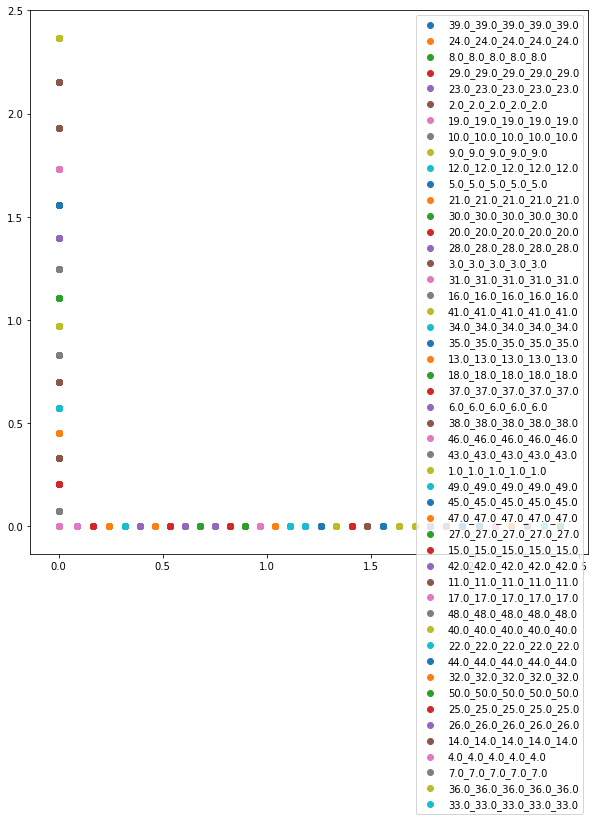

In [228]:
#Analysis

plt.figure(1, figsize=(10, 10))

for seq in unique_seqs:
    df_current = df_seqs_vectors[df_seqs_vectors['label']==seq]
    plt.scatter(df_current['x'].values, df_current['y'].values, color=next(palette), label=seq)

plt.legend(loc='best')
plt.show()